# Continuous-Space Super-Resolution of fODFs in Diffusion MRI

Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import functools
import io
import datetime
import time
import math
import itertools
import os
import shutil
import pathlib
import copy
import pdb
import inspect
import random
import subprocess
import sys
import warnings
from pathlib import Path
import typing
import zipfile

import dotenv

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data management libraries.
import nibabel as nib
import nibabel.processing
from natsort import natsorted
from pprint import pprint as ppr
from box import Box

# Computation & ML libraries.
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchio
from pytorch_lightning.lite import LightningLite
import monai
import einops
import torchinfo

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

direnv: loading ~/Projects/pitn/.envrc


In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24256MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


In [4]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():
    # GPU information
    try:
        gpu_info = pitn.utils.system.get_gpu_specs()
        print(gpu_info)
    except NameError:
        print("CUDA Version: ", torch.version.cuda)
else:
    print("CUDA not in use, falling back to CPU")

In [5]:
# cap is defined in an ipython magic command
print(cap)

Author: Tyler Spears

Last updated: 2022-10-11T18:16:02.564741-04:00

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.15.0-48-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: 3f8cf1ec31cd199777524dd03ff77e0b4a3501bc

einops    : 0.4.1
sys       : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]
seaborn   : 0.11.2
numpy     : 1.23.1
monai     : 1.0.0
torchinfo : 1.7.1
matplotlib: 3.5.2
pandas    : 1.4.3
pitn      : 0.0.post1.dev206+gf002231.d20220911
nibabel   : 4.0.1
torch     : 1.12.1
torchio   : 0.18.84

==================================================GPU Specs==================================================
  id  Name              Driver Version      CUDA Version  Total Memory    uuid
----  ----------------  ----------------  --------------  --------------  ----------------------------------------
  

In [6]:
d = torch.rand(4, 79, 84, 79)
aff = torch.eye(4)
tf = torchio.transforms.Resample((2, 2, 2))
tf(torchio.Image(**{"tensor": d, "affine": aff}, type=torchio.ScalarImage)).data.shape

torch.Size([4, 40, 42, 40])

In [7]:
F.interpolate(
    d[
        None,
    ],
    scale_factor=(0.5, 0.5, 0.5),
    mode="area",
).shape

torch.Size([1, 4, 39, 42, 39])

In [8]:
d = Path("/data/srv/data/pitn/hcp/896778/T1w/Diffusion/data.nii.gz")
nib_im = nib.load(d)
im = nib_im.get_fdata()
aff = nib_im.affine

In [34]:
md = monai.data.MetaTensor(einops.rearrange(im, "x y z c -> c x y z"), affine=aff)

In [ ]:
md

In [52]:
import fractions

fractions.Fraction.from_float(1.25 / 2).limit_denominator(50)

Fraction(5, 8)

tensor([[  -1.2500,    0.0000,    0.0000,   93.7500],
        [   0.0000,    1.2500,    0.0000, -127.2500],
        [   0.0000,    0.0000,    1.2500,  -75.7500],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
(288, 152, 176, 152)
(288, 95, 110, 95)
tensor([[  -2.0000,    0.0000,    0.0000,   93.3750],
        [   0.0000,    2.0000,    0.0000, -126.8750],
        [   0.0000,    0.0000,    2.0000,  -75.3750],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)


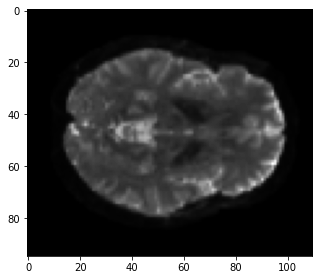

In [46]:
pad_tf = monai.transforms.DivisiblePad(8)
res = pad_tf(torch.clone(md))
print(res.affine)
print(res.shape)
res = monai.transforms.Zoom(((0.625, 0.625, 0.625)), mode="area", keep_size=False)(res)
print(res.shape)
print(res.affine)

plt.imshow(res[0, :, :, 35], cmap="gray")

tensor([[  -2.0000,    0.0000,    0.0000,   89.0000],
        [   0.0000,    2.0000,    0.0000, -125.8750],
        [   0.0000,    0.0000,    2.0000,  -71.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
tensor([[  -1.2500,    0.0000,    0.0000,   90.0000],
        [   0.0000,    1.2500,    0.0000, -126.0000],
        [   0.0000,    0.0000,    1.2500,  -72.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)


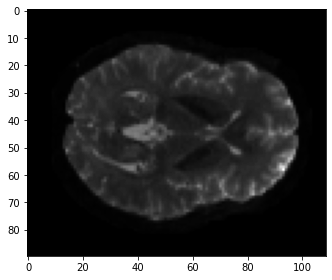

In [39]:
scale_tf = monai.transforms.Affine(
    scale_params=(8 / 5, 8 / 5, 8 / 5),
    mode=1,
    padding_mode="reflect",
    spatial_size=(90, 109, 90),
)
r = scale_tf(torch.clone(md))
print(r[0].affine)
print(md.affine)

plt.imshow(r[0][0, :, :, 35], cmap="gray")

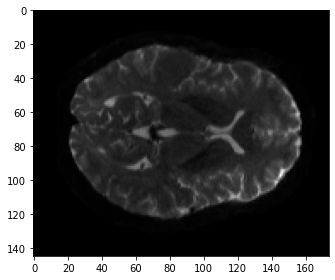

In [42]:
plt.imshow(md[0, :, :, 60], cmap="gray")

In [31]:
r[0].affine
md.affine

tensor([[ -1.0000,   0.0000,   0.0000, -13.3125],
        [  0.0000,   1.0000,   0.0000,   2.8750],
        [  0.0000,   0.0000,   1.0000,  31.3125],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)

In [29]:
scale_op = np.asarray([[2, 0, 0, 0], [0, 2, 0, 41], [0, 0, 2, -2], [0, 0, 0, 1]])
np.eye(4).dot(scale_op)

array([[ 2.,  0.,  0.,  0.],
       [ 0.,  2.,  0., 41.],
       [ 0.,  0.,  2., -2.],
       [ 0.,  0.,  0.,  1.]])

In [30]:
np.linalg.solve(np.eye(4), scale_op)

array([[ 2.,  0.,  0.,  0.],
       [ 0.,  2.,  0., 41.],
       [ 0.,  0.,  2., -2.],
       [ 0.,  0.,  0.,  1.]])

## Experiment & Parameters Setup

In [ ]:
p = Box(default_box=True)

# General experiment-wide params
###############################################
p.experiment_name = "sr_debug"
p.override_experiment_name = False
p.results_dir = "/data/srv/outputs/pitn/results/runs"
p.tmp_results_dir = "/data/srv/outputs/pitn/results/tmp"
p.train_val_test_split_file = random.choice(
    list(Path("./data_splits").glob("HCP*_split*.csv"))
)
###############################################
p.train.in_patch_size = (64, 64, 64)
p.train.batch_size = 1
p.train.samples_per_subj_per_epoch = 100
p.train.max_epochs = 50
p.train.loss = "mse"

# If a config file exists, override the defaults with those values.
try:
    if "PITN_CONFIG" in os.environ.keys():
        config_fname = Path(os.environ["PITN_CONFIG"])
    else:
        config_fname = pitn.utils.system.get_file_glob_unique(Path("."), r"config.*")
    f_type = config_fname.suffix.casefold()
    if f_type in {".yaml", ".yml"}:
        f_params = Box.from_yaml(filename=config_fname)
    elif f_type == ".json":
        f_params = Box.from_json(filename=config_fname)
    elif f_type == ".toml":
        f_params = Box.from_toml(filename=config_fname)
    else:
        raise RuntimeError()

    p.merge_update(f_params)

except:
    print("WARNING: Config file not loaded")
    pass

# Remove the default_box behavior now that params have been fully read in.
_p = Box(default_box=False)
_p.merge_update(p)
p = _p

## Data Loading

In [ ]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path(
    "/data/srv/tmp/data/pitn/hcp/derivatives/downsample/scale-2.00mm/vol"
)

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()

## Model

In [ ]:
class INRSystem(LightningLite):
    def run(self):
        pass

    def validate(self, model, val_dataset):
        pass

    def test(self, model, test_dataset):
        pass

## Training

## Testing & Visualization